## Importy

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('titanic.csv')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

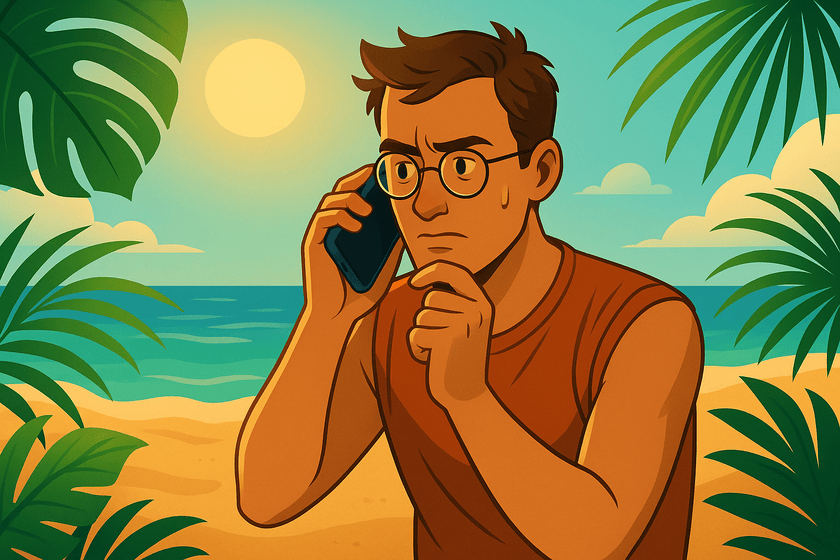

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


# Data setup

In [3]:
df = pd.read_csv(base_path)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         793 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,793.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,33.123938
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,51.578312
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.925000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare            98
Cabin          687
Embarked         2
dtype: int64

Kolumny jak: PassengerId, Name, Cabin i Ticket wypadałoby usunąć.

* PassengerId to nasza iteracja, która nic nie wnosi do EDA, ani do potencjalnego trenowania modelu
* Name tak samo
* Cabin tak jak widać powyżej ma problem znikania, a dokładnie 687 razy
* To samo numer ticketu
* Z fare i age postępuje tak samo, nadpisając je średnią 
* Embarked ustawiam na port, z którego najczęściej wsiadali

In [8]:
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Fare'].fillna(df['Fare'].mean(), inplace = True )
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(['Cabin','Name', 'PassengerId', 'Ticket'],axis = 1,inplace=True)
df.dropna()

df_copy = df

In [9]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Warto zamienić reprezentacje słowną ( litery ) na reprezentację danych poprzez liczby. Kolumny Sex i Embarked_{C,Q,S}

* Jako dodatek rozdzieliłem jeszcze Pclass na 3 osobne kolumny, żeby ładnie na heatmapie pokazać korelację pomiędzy wykupioną klasą, a szansą na przetrwanie

In [10]:
df = pd.get_dummies(df, columns=['Embarked', 'Sex', 'Pclass']).astype(int)

In [11]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22,1,0,7,0,0,1,0,1,0,0,1
1,1,38,1,0,71,1,0,0,1,0,1,0,0
2,1,26,0,0,7,0,0,1,1,0,0,0,1
3,1,35,1,0,53,0,0,1,1,0,1,0,0
4,0,35,0,0,8,0,0,1,0,1,0,0,1


# Dane wyglądają dobrze, więc czas na wykresiki

In [12]:
print(list(df_copy.columns))

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


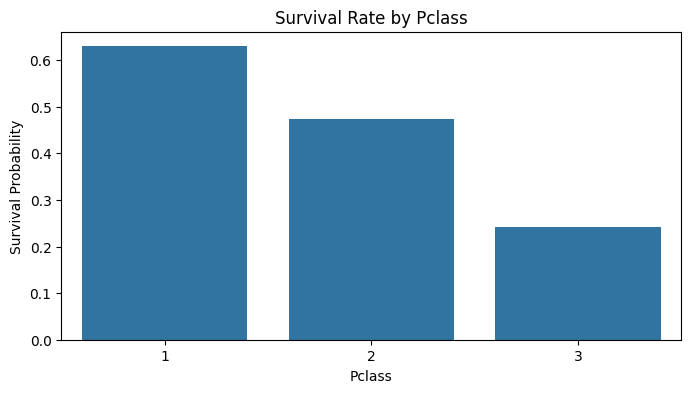

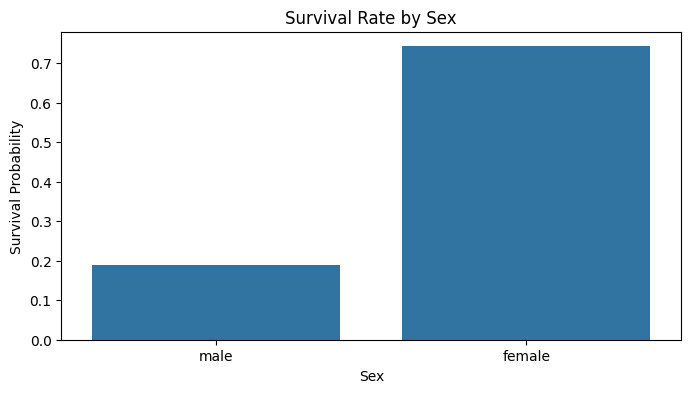

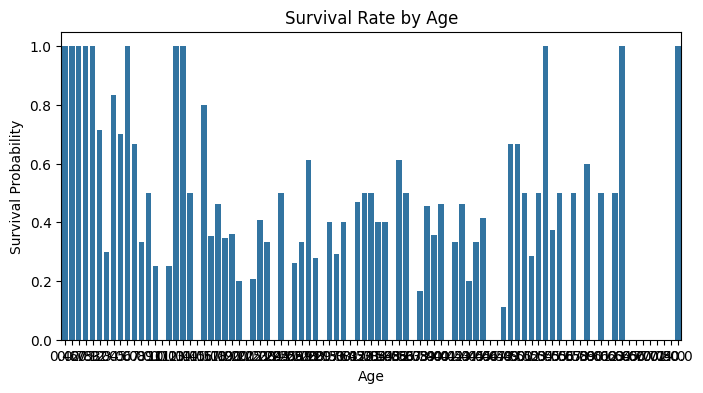

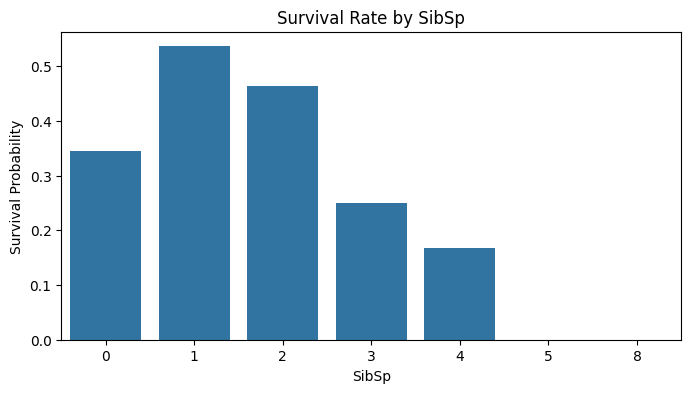

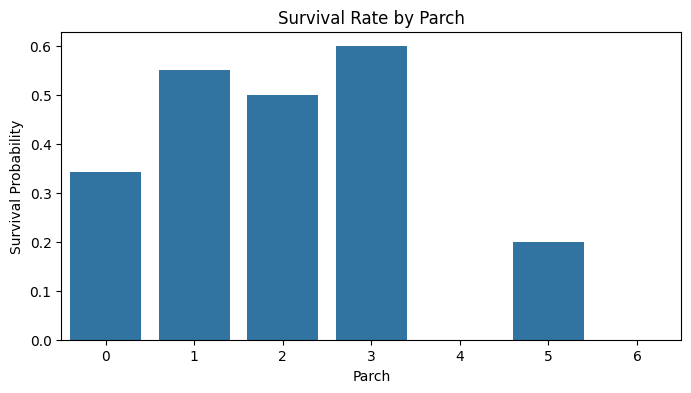

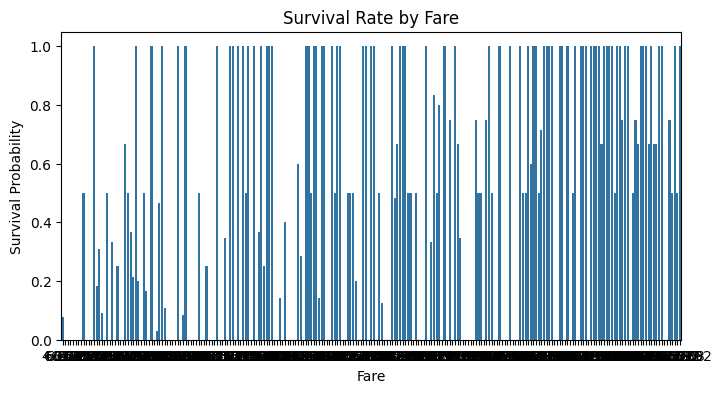

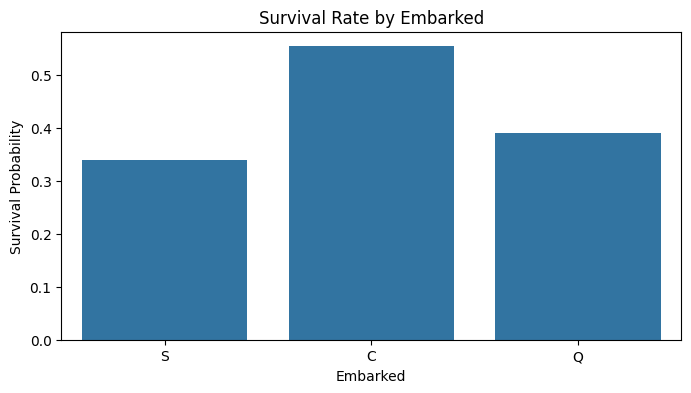

In [13]:
for feature in ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_copy, x=feature, y='Survived', errorbar=None)
    plt.title(f'Survival Rate by {feature}')
    plt.ylabel('Survival Probability')
    plt.show()

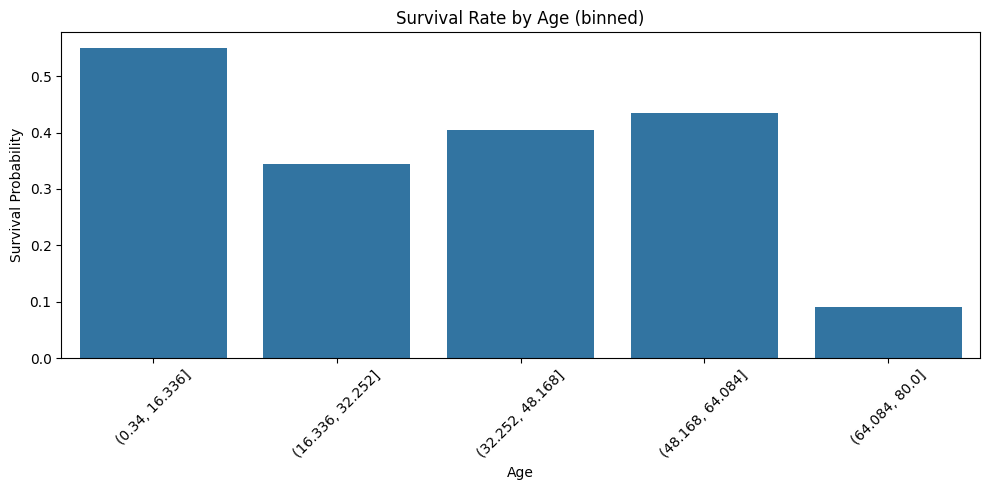

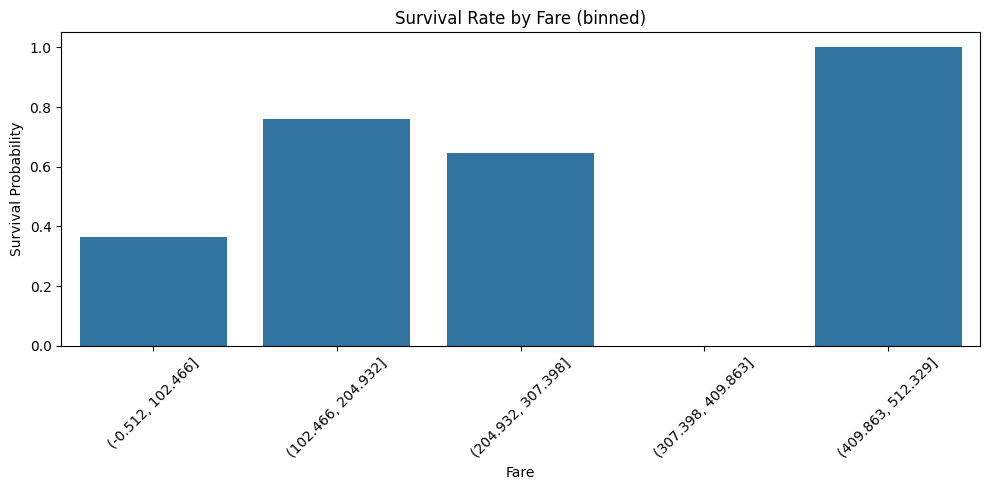

In [14]:
x = ['Age', 'Fare']

for feature in x:

    df_copy[f'{feature}_bin'] = pd.cut(df_copy[feature], bins=5)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_copy, x=f'{feature}_bin', y='Survived', errorbar=None)
    plt.xticks(rotation=45)
    plt.title(f'Survival Rate by {feature} (binned)')
    plt.ylabel('Survival Probability')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

Tutaj ponownie widać, że cena biletu == lepsza klasa, podnosiła szansę na przetrwanie oraz, że dzieci miały większą szansę na przetrwanie

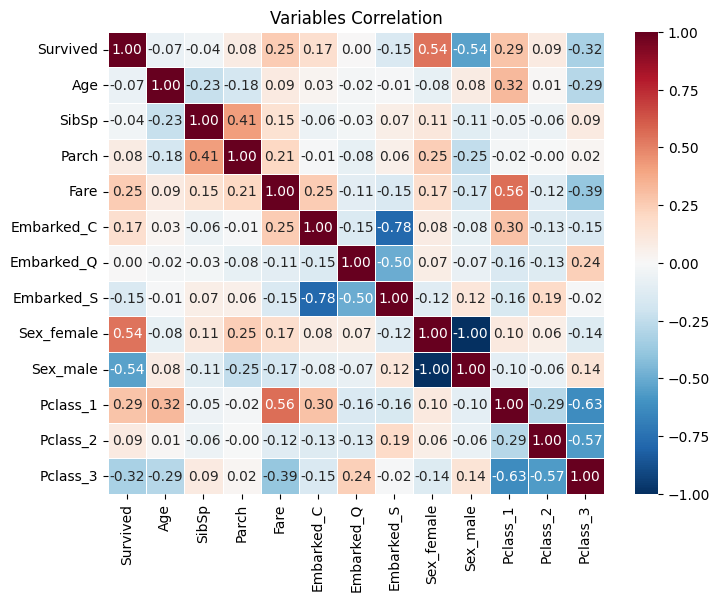

In [15]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5)
plt.title('Variables Correlation')
plt.show()

Znowu będzie trochę pisania:
Patrzymy na najbardziej dla nas interesującą wartość -> survive i kierujemy się wzrokiem w prawo, pominę neutralne korelacje

Pozytywna korelacja:

* Sex_female: 0.54 – Kobiety miały znacznie większą szansę na przetrwanie i możemy również wywnioskować z heatmapy, że to płeć była cechą dominującą w tej kwestii.
* Pclass_1: 0.29 – Pasażerowie pierwszej klasy mieli znacząco większe szanse na przeżycie.
* Pclass_2: 0.09 – Pasażerowie drugiej klasy mieli nieco większe szanse na przeżycie, lecz nieznacznie.


Ujemne korelacje:

* Sex_male: -0.54 – Mężczyźni mieli znacznie mniejsze szanse na przeżycie.
* Pclass_3: -0.32 – Pasażerowie trzeciej klasy mieli mniejsze szanse na przeżycie.
* Embarked_S: -0.15 – Pasażerowie z Southampton mieli nieznacznie niższe szanse na przeżycie.
* Embarked_C: 0.17 – Pasażerowie z Cherbourga mieli nieznacznie większe szanse na przeżycie.


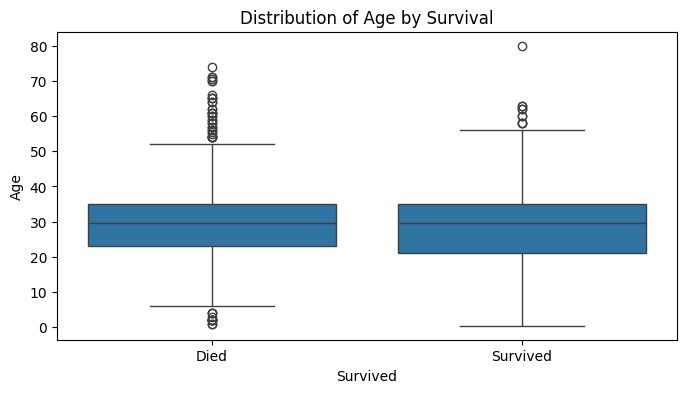

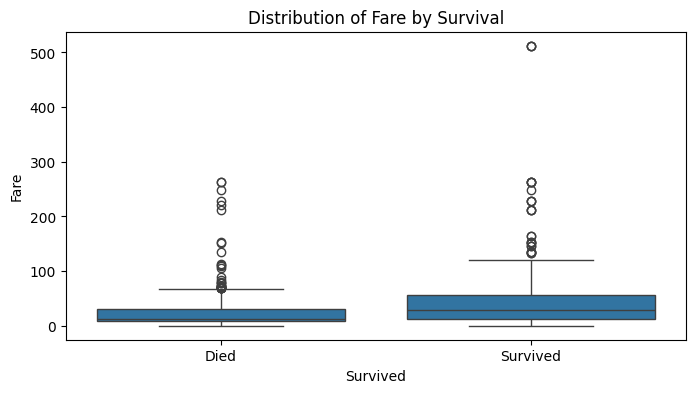

In [16]:
for feature in ['Age', 'Fare']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_copy, x='Survived', y=feature)
    plt.title(f'Distribution of {feature} by Survival')
    plt.xticks([0, 1], ['Died', 'Survived'])
    plt.show()

<Axes: xlabel='FamilySize', ylabel='Survived'>

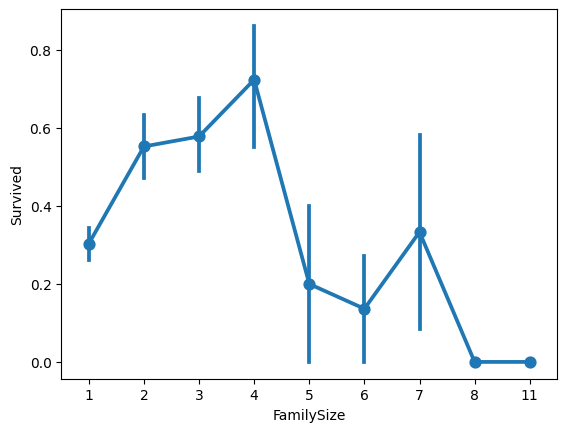

In [17]:
df_copy['FamilySize'] = df_copy['SibSp'] + df_copy['Parch'] + 1
sns.pointplot(data=df_copy, x='FamilySize', y='Survived')

Tutaj jeszcze można się dopatrywać, że mniejsza liczba członków rodziny mogła zwiększyć czyjeś prawdopodobieństwo przetrwania.

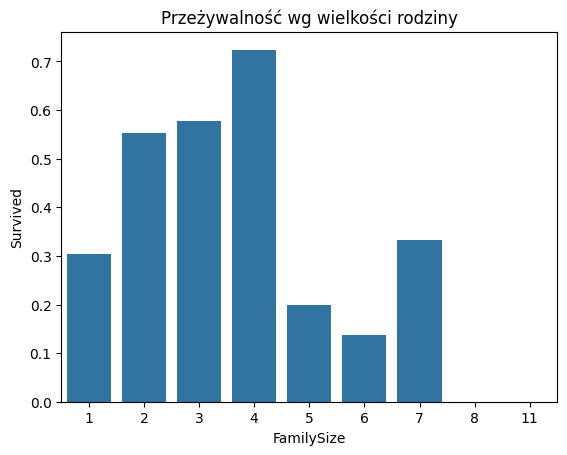

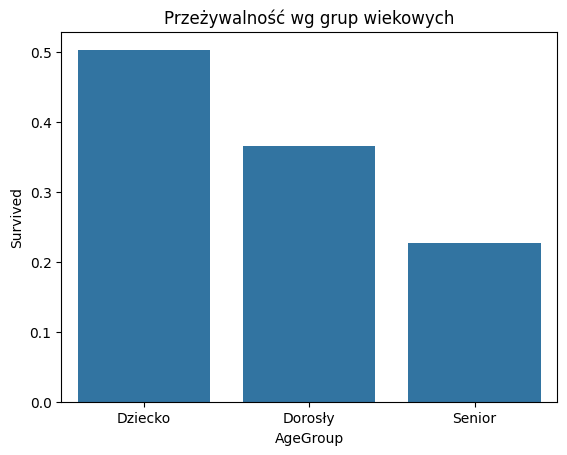

In [18]:
df_copy['FamilySize'] = df_copy['SibSp'] + df_copy['Parch'] + 1
sns.barplot(data=df_copy, x='FamilySize', y='Survived', errorbar=None)
plt.title('Przeżywalność wg wielkości rodziny')
plt.show()

df_copy['AgeGroup'] = pd.cut(df_copy['Age'], bins=[0, 18, 60, 100], labels=['Dziecko', 'Dorosły', 'Senior'])
sns.barplot(data=df_copy, x='AgeGroup', y='Survived', errorbar=None)
plt.title('Przeżywalność wg grup wiekowych')
plt.show()

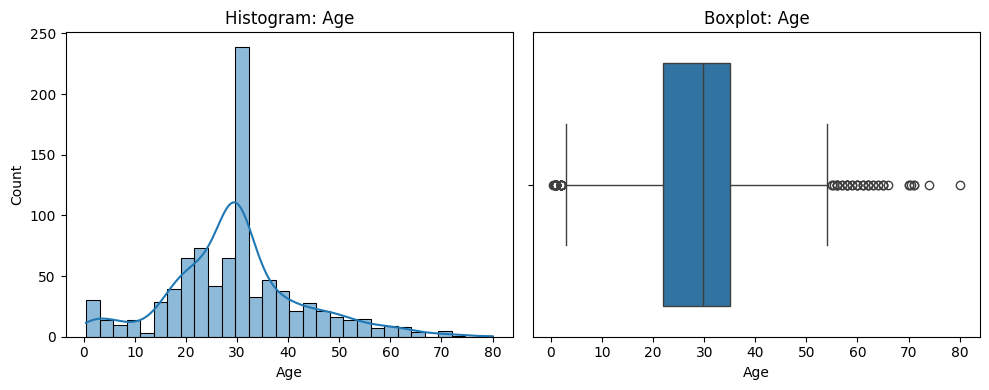

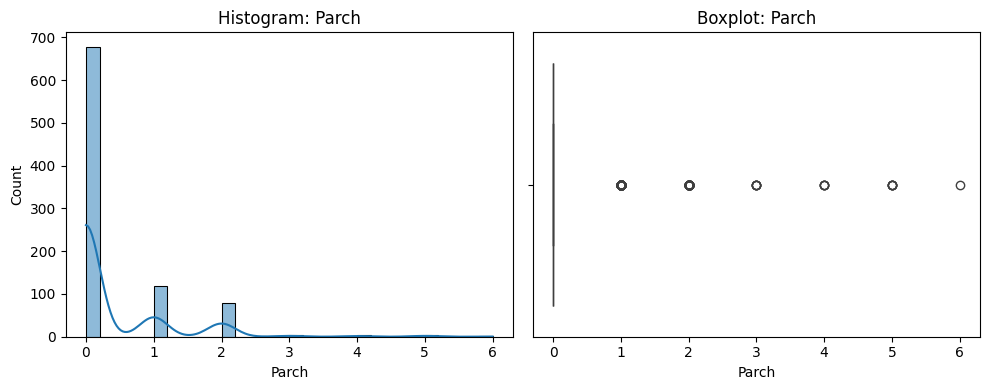

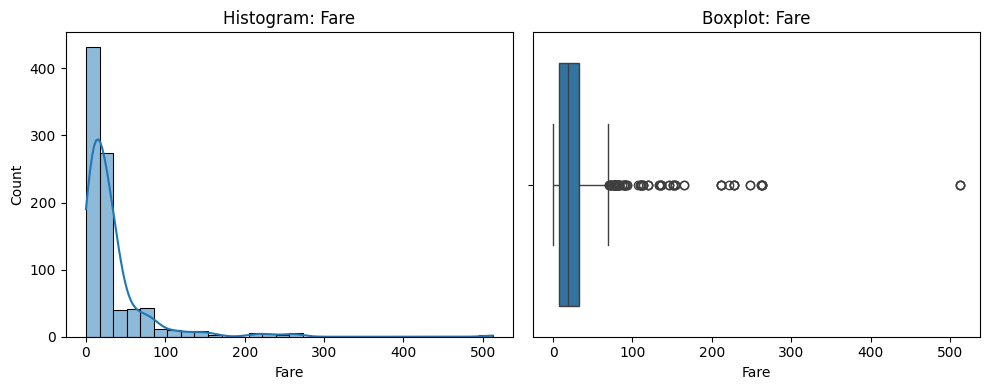

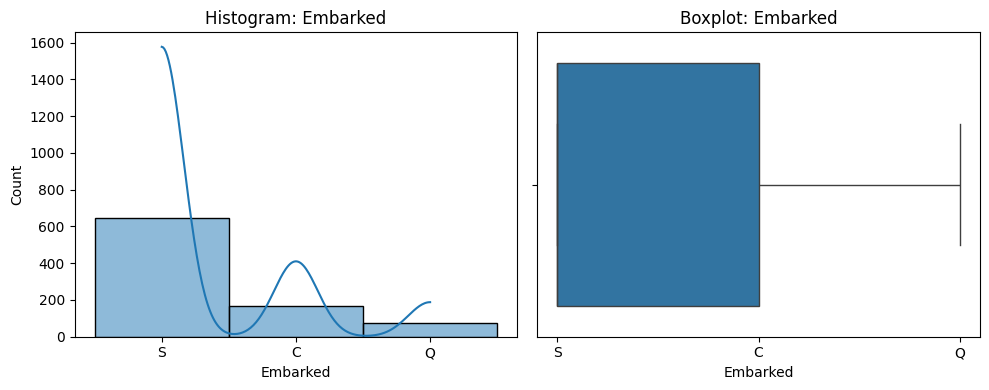

In [19]:
for col in ['Age','Parch', 'Fare', 'Embarked']:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_copy[col], bins=30, kde=True)
    plt.title(f'Histogram: {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_copy[col])
    plt.title(f'Boxplot: {col}')
    
    plt.tight_layout()
    plt.show()

Tutaj jeszcze można poszukać outlierów, widać je w sekcji fare, gdzie występują droższe bilety za lepsze klasy, ale są jeszcze "mocne" outliery, jakiegoś rodzaju klasa dla VIP-ów czy jakiegoś rodzaju luksusowe pokoje w ilości pewnie do 5 jednostek, ale to zaraz zobaczymy. To samo w kolumnie Age, gdzie są i dzieci i bardzo starsi ludzie, którzy odbiegają od średniej jak i mediany i dominanty w znacznym stopniu. To samo jest w parch, gdzie od singli czy par / par z dzieckiem odbiegają całe rodziny. Embarked raczej wygląda okej.

In [20]:
for col in ['Age', 'Fare', 'Parch', 'FamilySize']:
    max_value = df_copy[col].max()
    count = (df_copy[col] == max_value).sum()
    print(f'Największa wartość w kolumnie "{col}": {max_value}, liczba osób: {count}')

Największa wartość w kolumnie "Age": 80.0, liczba osób: 1
Największa wartość w kolumnie "Fare": 512.3292, liczba osób: 3
Największa wartość w kolumnie "Parch": 6, liczba osób: 1
Największa wartość w kolumnie "FamilySize": 11, liczba osób: 7


Zatem to są nasze największe outliery, które można było zauważyc wizualnie.